Epoch 1/100
18/18 [==============================] - 6s 118ms/step - loss: 0.2078 - val_loss: 0.4520
Epoch 2/100
18/18 [==============================] - 1s 62ms/step - loss: 0.1060 - val_loss: 0.3700
Epoch 3/100
18/18 [==============================] - 1s 63ms/step - loss: 0.1061 - val_loss: 0.4866
Epoch 4/100
18/18 [==============================] - 1s 61ms/step - loss: 0.0929 - val_loss: 0.3716
Epoch 5/100
18/18 [==============================] - 1s 59ms/step - loss: 0.0962 - val_loss: 0.3463
Epoch 6/100
18/18 [==============================] - 1s 60ms/step - loss: 0.0894 - val_loss: 0.3229
Epoch 7/100
18/18 [==============================] - 1s 59ms/step - loss: 0.0886 - val_loss: 0.3098
Epoch 8/100
18/18 [==============================] - 1s 60ms/step - loss: 0.0885 - val_loss: 0.4095
Epoch 9/100
18/18 [==============================] - 1s 61ms/step - loss: 0.0834 - val_loss: 0.2801
Epoch 10/100
18/18 [==============================] - 1s 59ms/step - loss: 0.1043 - val_loss: 0.266

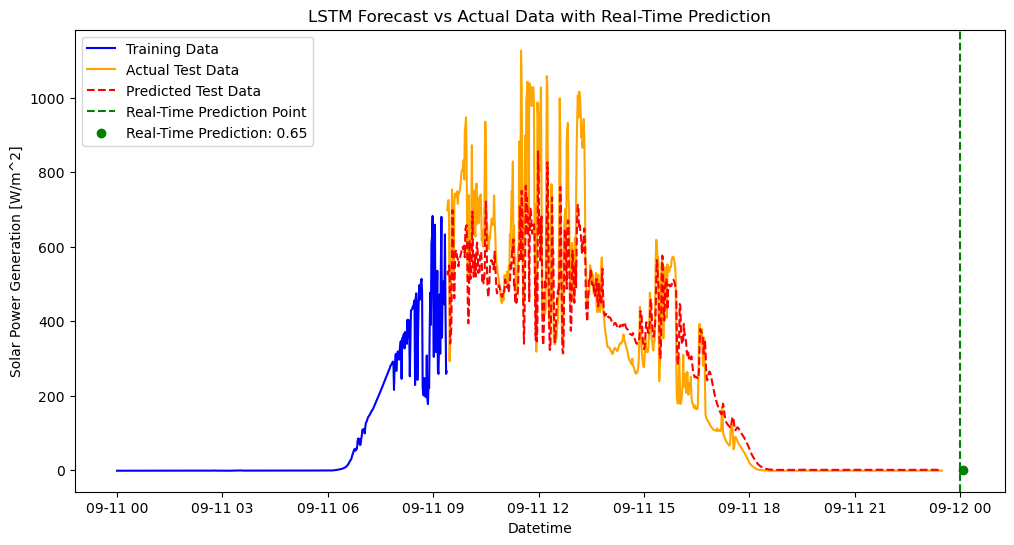

In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess data
data = pd.read_csv('texas_110924.csv')

# Create DataFrame
df = pd.DataFrame(data)

# Convert DATE to datetime format and CST to time format
df['DATE'] = pd.to_datetime(df['DATE (MM/DD/YYYY)'], format='%m/%d/%Y')
df['CST'] = pd.to_datetime(df['CST'], format='%H:%M').dt.time

# Combine DATE and CST into a single datetime column
df['Datetime'] = df.apply(lambda row: pd.Timestamp.combine(row['DATE'], row['CST']), axis=1)
df.set_index('Datetime', inplace=True)

# Select the column we want and drop missing values
df = df[['Global Horizontal [W/m^2]']].dropna()

# Convert DataFrame to NumPy array for scaling
values = df.values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 5))
scaled_data = scaler.fit_transform(values)

# Create dataset for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Set the time step and split data for training/testing
time_step = 30
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

train_size = int(len(X) * 0.4)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build and train LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

# Predict the test set results
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Function to handle real-time predictions with new data
def predict_real_time(new_data):
    # Convert new_data to a NumPy array if it's not already
    new_data_array = np.array(new_data).reshape(-1, 1)
    
    # Scale the new data using the same scaler fitted on the original data
    scaled_new_data = scaler.transform(new_data_array)

    # Use the last 'time_step' of the scaled data as input for the model
    input_data = scaled_new_data[-time_step:].reshape(1, time_step, 1)

    # Make prediction for the next step
    prediction = model.predict(input_data)

    # Inverse scale the predicted value back to original scale
    prediction = scaler.inverse_transform(prediction)
    
    return prediction[0][0]

# Simulate real-time data
new_data = df['Global Horizontal [W/m^2]'].tail(time_step).values
next_prediction = predict_real_time(new_data)

# Plot the historical data, predicted test data, and real-time forecast
plt.figure(figsize=(12, 6))

# Plot historical actual data (including training and test data)
plt.plot(df.index[:train_size], df['Global Horizontal [W/m^2]'][:train_size], color='blue', label='Training Data')
plt.plot(df.index[train_size:train_size + len(y_test)], y_test_rescaled, color='orange', label='Actual Test Data')

# Plot predicted test data
plt.plot(df.index[train_size:train_size + len(predictions_rescaled)], predictions_rescaled, color='red', linestyle='--', label='Predicted Test Data')

# Plot real-time prediction (append to the last index)
plt.axvline(x=df.index[-1], color='green', linestyle='--', label='Real-Time Prediction Point')
plt.scatter(df.index[-1] + pd.Timedelta(minutes=5), next_prediction, color='green', label=f'Real-Time Prediction: {next_prediction:.2f}', zorder=5)

plt.title('LSTM Forecast vs Actual Data with Real-Time Prediction')
plt.xlabel('Datetime')
plt.ylabel('Solar Power Generation [W/m^2]')
plt.legend()
plt.show()

1/1 [==============================] - 0s 36ms/step


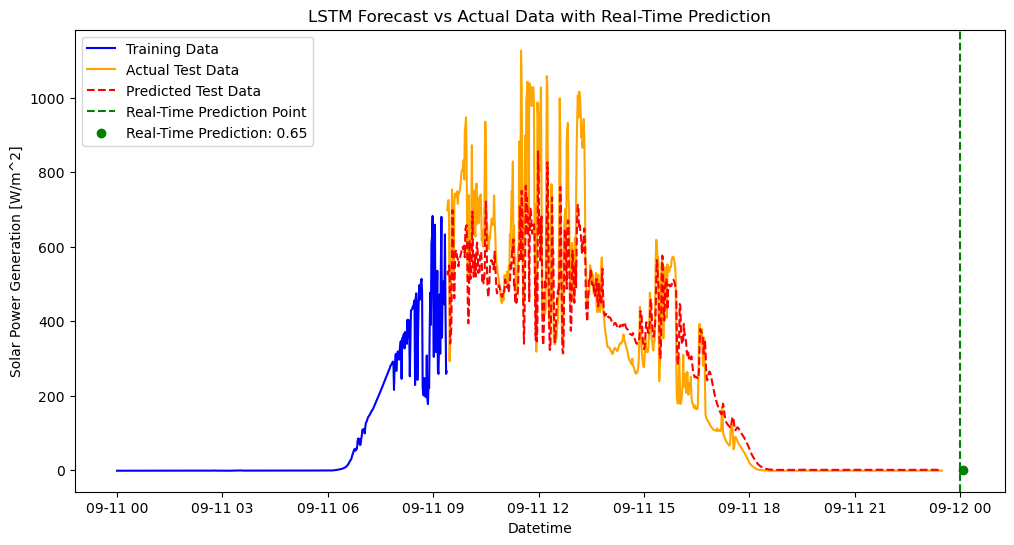

In [6]:
# Simulate real-time data
new_data = df['Global Horizontal [W/m^2]'].tail(time_step).values
next_prediction = predict_real_time(new_data)

# Plot the historical data, predicted test data, and real-time forecast
plt.figure(figsize=(12, 6))

# Plot historical actual data (including training and test data)
plt.plot(df.index[:train_size], df['Global Horizontal [W/m^2]'][:train_size], color='blue', label='Training Data')
plt.plot(df.index[train_size:train_size + len(y_test)], y_test_rescaled, color='orange', label='Actual Test Data')

# Plot predicted test data
plt.plot(df.index[train_size:train_size + len(predictions_rescaled)], predictions_rescaled, color='red', linestyle='--', label='Predicted Test Data')

# Plot real-time prediction (append to the last index)
plt.axvline(x=df.index[-1], color='green', linestyle='--', label='Real-Time Prediction Point')
plt.scatter(df.index[-1] + pd.Timedelta(minutes=5), next_prediction, color='green', label=f'Real-Time Prediction: {next_prediction:.2f}', zorder=5)

plt.title('LSTM Forecast vs Actual Data with Real-Time Prediction')
plt.xlabel('Datetime')
plt.ylabel('Solar Power Generation [W/m^2]')
plt.legend()
plt.show()